Hypertension and various parameters exploration:  

To do:  

Import packages  

Import the NHANES_analysis_data. This has the activity, mortality data used in the main reference: Organizing and analyzing the activity data in NHANES. The activity data is from 2003 - 2006 (double check years from the documentation)  


Get the list of subjects into a separate files. This list will be used to get the specific data from any of the other data files. This list represents the subjects with mortality data and activity data, the latter of which has been extracted in a complex precess from very large accelerometer data files.  




In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nhanes.utils import get_nhanes_year_code_dict, get_source_code_from_filepath
from nhanes.utils import EmptySectionError, make_long_variable_name
from nhanes.utils import get_vars_to_keep, get_datasets




# Load the file
file_path = '../data/NHANES_analysis_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and the column names to understand its structure
data.head(), data.columns



(   Unnamed: 0   SEQN  PAXCAL  PAXSTAT  WEEKDAY  SDDSRVYR  eligstat  mortstat  \
 0          29  21009       1        1        1         3         1         0   
 1          36  21010       1        1        7         3         1         0   
 2          43  21012       1        1        5         3         1         0   
 3          57  21015       1        1        5         3         1         1   
 4          85  21019       1        1        1         3         1         0   
 
    causeavl  permth_exm  ...        si3       mi4        si4        mi5  \
 0       NaN          91  ...  10.111268 -5.672251   4.758967  -7.065432   
 1       NaN         102  ...  15.838752  4.406696  14.108764   4.135414   
 2       NaN          89  ...  16.225173 -0.181256  15.776060 -14.312063   
 3       1.0          24  ...   7.191713 -2.059667  13.697082  -3.361531   
 4       NaN         100  ...  14.528884  4.161097   9.919867  -5.008378   
 
          si5       mi6        si6      sPC1      sPC5

In [7]:
# Set the path to the directory containing the NHANES data files
# data_dir = '/path/to/data/files'
data_dir =  '../data/raw_data/2003-2004a'
# Get a list of all NHANES data files in the data directory
data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(data_files)

['ACQ_C.csv', 'ALQ_C.csv', 'BIX_C.csv', 'BMX_C.csv', 'BPQ_C.csv', 'BPX_C.csv', 'CDQ_C.csv', 'CIQDEP_C.csv', 'CIQGAD_C.csv', 'CIQPAN_C.csv', 'CVX_C.csv', 'DBQ_C.csv', 'DEMO_C.csv', 'DIQ_C.csv', 'DUQ_C.csv', 'DXXAG_C.csv', 'dxx_c.csv', 'HSQ_C.csv', 'HUQ_C.csv', 'KIQ_P_C.csv', 'KIQ_U_C.csv', 'L11_C.csv', 'L13AM_C.csv', 'L13_C.csv', 'L16_C.csv', 'L40_C.csv', 'LEXAB_C.csv', 'LEXPN_C.csv', 'MCQ_C.csv', 'OCQ_C.csv', 'OHQ_C.csv', 'OHXADD_C.csv', 'OHXDEN_C (1).csv', 'OHXDEN_C.csv', 'OHXPRL_C.csv', 'OHXPRU_C.csv', 'OHXREF_C.csv', 'OSQ_C.csv', 'PAQIAF_C.csv', 'PAQ_C.csv', 'PFQ_C.csv', 'RDQ_C.csv', 'RXQANA_C.csv', 'RXQ_RX_C.csv', 'SMQ_C.csv', 'SSFA_C.csv', 'SSTROP_A.csv', 'VIX_C.csv', 'WHQ_C.csv']


In [25]:
data.head(), data.columns

(   Unnamed: 0   SEQN  PAXCAL  PAXSTAT  WEEKDAY  SDDSRVYR  eligstat  mortstat  \
 0          29  21009       1        1        1         3         1         0   
 1          36  21010       1        1        7         3         1         0   
 2          43  21012       1        1        5         3         1         0   
 3          57  21015       1        1        5         3         1         1   
 4          85  21019       1        1        1         3         1         0   
 
    causeavl  permth_exm  ...        si3       mi4        si4        mi5  \
 0       NaN          91  ...  10.111268 -5.672251   4.758967  -7.065432   
 1       NaN         102  ...  15.838752  4.406696  14.108764   4.135414   
 2       NaN          89  ...  16.225173 -0.181256  15.776060 -14.312063   
 3       1.0          24  ...   7.191713 -2.059667  13.697082  -3.361531   
 4       NaN         100  ...  14.528884  4.161097   9.919867  -5.008378   
 
          si5       mi6        si6      sPC1      sPC5

In [8]:
gender_distribution = data['Gender'].value_counts()
print(gender_distribution)

Gender
Male      1611
Female    1587
Name: count, dtype: int64


In [9]:
# Distribution of categorical variables
race_distribution = data['Race'].value_counts()
print(race_distribution)

Race
White               1862
Black                601
Mexican American     572
Other                102
Other Hispanic        61
Name: count, dtype: int64


In [11]:

# Check for missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)

Unnamed: 0    0
SEQN          0
PAXCAL        0
PAXSTAT       0
WEEKDAY       0
             ..
mi6           0
si6           0
sPC1          0
sPC5          0
sPC6          0
Length: 81, dtype: int64


In [12]:
# Extract only numeric columns from the data
numeric_data = data.select_dtypes(include=[np.number])

# Descriptive statistics for numeric columns
desc_stats = numeric_data.describe()

# Distribution of categorical variables
race_distribution = data['Race'].value_counts()
gender_distribution = data['Gender'].value_counts()
htn_mcod_distribution = data['hyperten_mcod'].value_counts()

# Correlation matrix
correlation_matrix = numeric_data.corr()

desc_stats


,Unnamed: 0,SEQN,PAXCAL,PAXSTAT,WEEKDAY,SDDSRVYR,eligstat,mortstat,causeavl,permth_exm,...,si3,mi4,si4,mi5,si5,mi6,si6,sPC1,sPC5,sPC6
count,3198.000000,3198.000000,3198.0,3198.0,3198.000000,3198.000000,3198.0,3198.000000,500.000000,3198.000000,...,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,49371.141964,30919.298624,1.0,1.0,3.679174,3.474984,1.0,0.156348,0.998000,77.272670,...,11.665560,-0.222842,11.307798,0.004076,10.121201,0.087158,9.727031,2.043132,2.289681,2.539408
std,29749.605212,5939.084536,0.0,0.0,2.128558,0.499452,0.0,0.363241,0.044721,20.902774,...,5.696092,8.457673,4.475771,7.956348,4.247787,6.676252,3.764082,1.000000,1.000000,1.000000
min,29.000000,21009.000000,1.0,1.0,1.000000,3.000000,1.0,0.000000,0.000000,1.000000,...,0.497092,-37.537116,0.880774,-42.814706,1.050055,-29.205554,0.493105,0.114740,0.118477,0.223690
25%,23643.500000,25782.000000,1.0,1.0,2.000000,3.000000,1.0,0.000000,1.000000,66.000000,...,7.646301,-5.445106,8.050198,-4.545309,7.037252,-4.133943,6.991985,1.326657,1.578341,1.828361
50%,47422.500000,30529.500000,1.0,1.0,3.000000,3.000000,1.0,0.000000,1.000000,80.000000,...,10.742802,0.205485,10.837037,0.553449,9.566671,0.048723,9.411755,1.866755,2.117929,2.421265
75%,75466.250000,36118.750000,1.0,1.0,6.000000,4.000000,1.0,0.000000,1.000000,92.000000,...,14.659543,5.182739,13.881407,5.180536,12.453932,4.159144,11.982522,2.519429,2.851911,3.139233
max,102376.000000,41468.000000,1.0,1.0,7.000000,4.000000,1.0,1.000000,1.000000,107.000000,...,47.108291,32.009470,31.643878,32.593000,39.060541,28.162747,27.628499,8.373436,8.965640,7.526146


In [13]:
race_distribution

Race
White               1862
Black                601
Mexican American     572
Other                102
Other Hispanic        61
Name: count, dtype: int64

In [37]:
gender_distribution

Gender
Male      1611
Female    1587
Name: count, dtype: int64

In [14]:
correlation_matrix

,Unnamed: 0,SEQN,PAXCAL,PAXSTAT,WEEKDAY,SDDSRVYR,eligstat,mortstat,causeavl,permth_exm,...,si3,mi4,si4,mi5,si5,mi6,si6,sPC1,sPC5,sPC6
Unnamed: 0,1.000000,0.999990,NaN,NaN,-0.014634,0.869527,NaN,-0.065932,0.025723,-0.416651,...,0.020429,-0.035820,0.041209,-0.017689,-0.000327,0.032428,-0.009895,0.054904,0.004705,-0.005110
SEQN,0.999990,1.000000,NaN,NaN,-0.014501,0.869202,NaN,-0.065865,0.025538,-0.416532,...,0.020289,-0.035765,0.041237,-0.017626,-0.000384,0.032301,-0.009912,0.054827,0.004629,-0.005158
PAXCAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAXSTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEEKDAY,-0.014634,-0.014501,NaN,NaN,1.000000,-0.026088,NaN,0.035768,-0.045781,-0.031975,...,-0.073421,0.092735,-0.014631,0.021158,-0.039878,-0.030959,0.008455,-0.075287,-0.026622,0.005867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mi6,0.032428,0.032301,NaN,NaN,-0.030959,0.044786,NaN,-0.029774,-0.000438,0.002024,...,0.074031,-0.133633,0.030222,0.053943,-0.001245,1.000000,0.034207,0.002006,-0.024923,0.029159
si6,-0.009895,-0.009912,NaN,NaN,0.008455,-0.010273,NaN,-0.149163,-0.005734,0.131263,...,0.272336,0.014471,0.245428,-0.038476,0.235533,0.034207,1.000000,0.180026,0.202309,0.868338
sPC1,0.054904,0.054827,NaN,NaN,-0.075287,0.061365,NaN,-0.092147,0.010153,0.043131,...,0.347595,-0.082409,0.243793,-0.201165,0.251435,0.002006,0.180026,1.000000,0.251844,0.211466
sPC5,0.004705,0.004629,NaN,NaN,-0.026622,0.007538,NaN,-0.129348,-0.080862,0.101710,...,0.365797,-0.085521,0.243052,-0.128905,0.774823,-0.024923,0.202309,0.251844,1.000000,0.231565


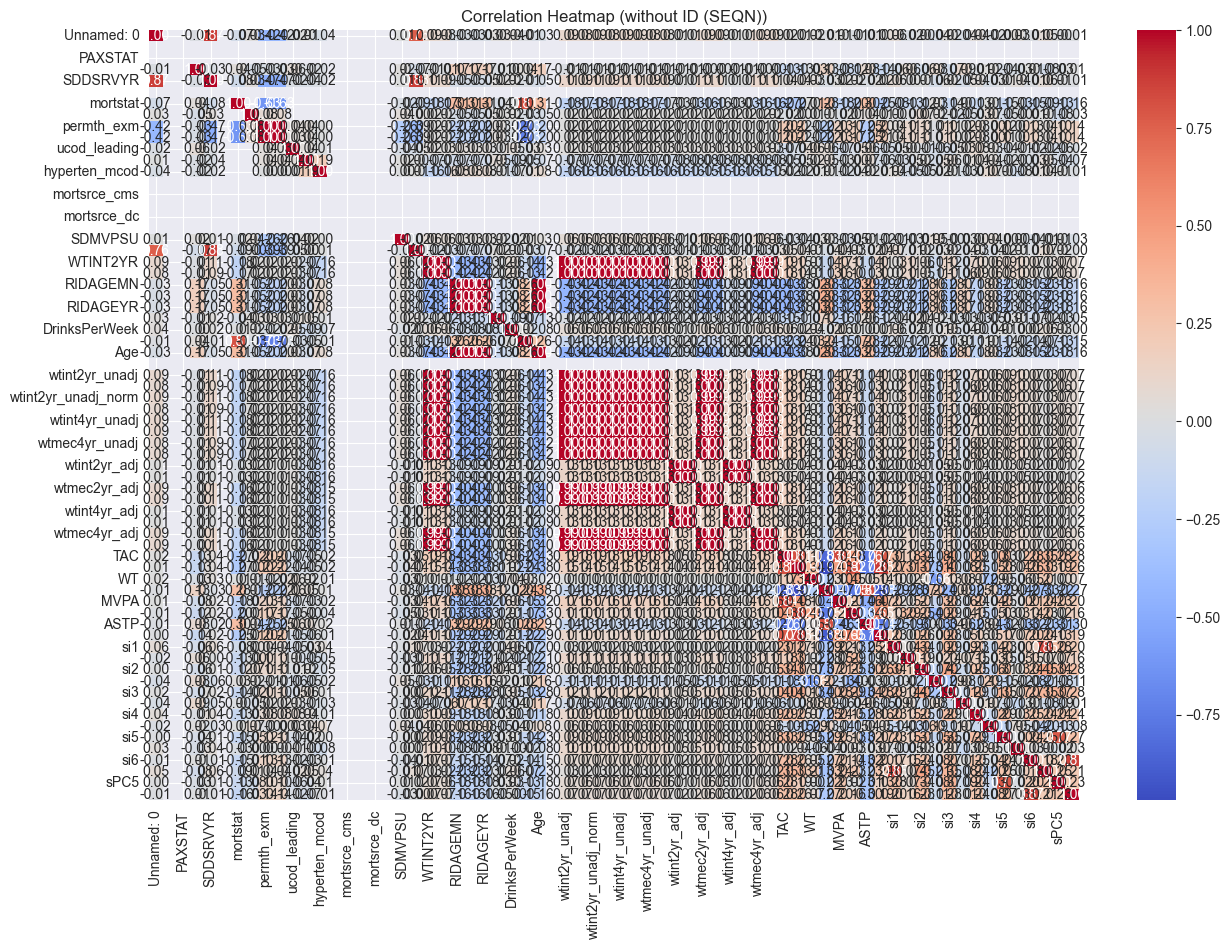

In [17]:
# Extract only numeric columns from the data
numeric_data = data.select_dtypes(include=[np.number])

# Drop the 'SEQN' column for the correlation matrix
correlation_matrix_no_id = numeric_data.drop('SEQN', axis=1).corr()

# Heatmap of the new correlation matrix without the ID column
plt.figure(figsize=(15, 10))
heatmap_no_id = sns.heatmap(correlation_matrix_no_id, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (without ID (SEQN))')
plt.show()